In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 100,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 100, Accuracy: 0.8580246913580247, Loss: 0.5510556609542282
Checkpoint 200, Accuracy: 0.8580246913580247, Loss: 0.5534381160029659
Checkpoint 300, Accuracy: 0.8580246913580247, Loss: 0.555733115584762
Checkpoint 400, Accuracy: 0.8580246913580247, Loss: 0.5580611758761935
Checkpoint 500, Accuracy: 0.8580246913580247, Loss: 0.5572405214662906


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.3323564 ]
 [0.39783618]
 [0.26980746]]
[0. 1. 0.] <-> [[0.46356723]
 [0.32962185]
 [0.2068109 ]]
[1. 0. 0.] <-> [[0.927595  ]
 [0.04763227]
 [0.02477274]]
[1. 0. 0.] <-> [[0.54631305]
 [0.27973765]
 [0.17394933]]
[1. 0. 0.] <-> [[0.8997758 ]
 [0.05603527]
 [0.04418893]]
[1. 0. 0.] <-> [[0.566086  ]
 [0.267735  ]
 [0.16617902]]
[1. 0. 0.] <-> [[0.8770903 ]
 [0.06221939]
 [0.0606903 ]]
[1. 0. 0.] <-> [[0.9129768 ]
 [0.05189223]
 [0.03513098]]
[1. 0. 0.] <-> [[0.49988046]
 [0.30900505]
 [0.19111449]]
[1. 0. 0.] <-> [[0.9147433 ]
 [0.05130652]
 [0.03395014]]
[1. 0. 0.] <-> [[0.86031216]
 [0.06602869]
 [0.0736591 ]]
[1. 0. 0.] <-> [[0.9234406 ]
 [0.04835053]
 [0.02820893]]
[1. 0. 0.] <-> [[0.9115677 ]
 [0.05235429]
 [0.03607795]]
[1. 0. 0.] <-> [[0.7973394 ]
 [0.13030267]
 [0.07235793]]
[0. 0. 1.] <-> [[0.38642192]
 [0.3706862 ]
 [0.24289192]]
[1. 0. 0.] <-> [[0.6004128 ]
 [0.24748151]
 [0.15210564]]
[0. 0. 1.] <-> [[0.2545987 ]
 [0.43405664]
 [0.31134468]]
[1. 0. 0.] <->

In [11]:
# Testing Performance

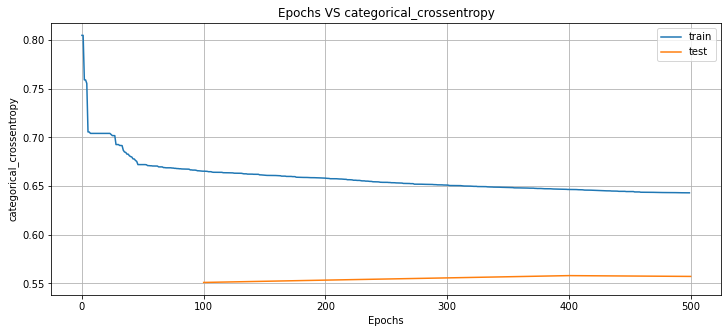

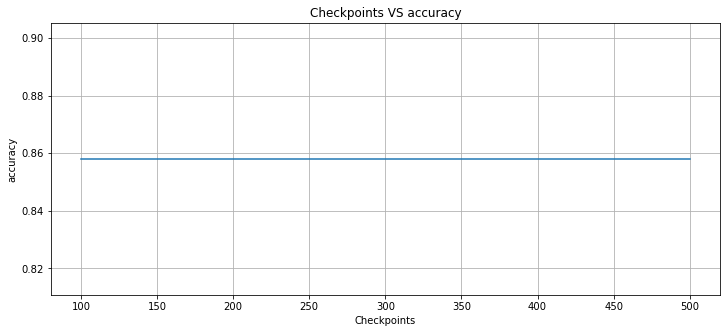

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8580246913580247, 'mean_square_error': 2.8879123289940027, 'categorical_crossentropy': 0.5510556609542282, 'precision': 0.7870370370370371, 'recall': 0.7870370370370371, 'f1': 0.7870370370370371, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 4}, 1: {'tp_hit': 2, 'fp_hit': 6, 'tn_hit': 87, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 4, 'tn_hit': 91, 'fn_hit': 6}}, 'checkpoint': 100} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 2.8879005150756267, 'categorical_crossentropy': 0.5534381160029659, 'precision': 0.7870370370370371, 'recall': 0.7870370370370371, 'f1': 0.7870370370370371, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 4}, 1: {'tp_hit': 2, 'fp_hit': 6, 'tn_hit': 87, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 4, 'tn_hit': 91, 'fn_hit': 6}}, 'checkpoint': 200} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 2.891339785716104, 'categorical_crossentropy': 0.555733115584762, 'precision': 0

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[-0.9248976]
 [ 1.108356 ]
 [-1.888568 ]
 [ 1.8001057]
 [-2.364497 ]]
 bias: [-2.30848]

Neuron 1: weights:
[[ 1.1181387 ]
 [-1.3424296 ]
 [-1.4657276 ]
 [-0.22221944]
 [ 0.30627418]]
 bias: [3.]

Neuron 2: weights:
[[3.       ]
 [1.401839 ]
 [3.       ]
 [3.       ]
 [2.7184546]]
 bias: [3.]

Neuron 3: weights:
[[ 1.1855012 ]
 [-1.7456396 ]
 [ 3.        ]
 [-2.287372  ]
 [ 0.44517568]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[-0.38543373]
 [ 1.2701457 ]
 [-3.        ]
 [-3.        ]]
 bias: [-0.90053046]

Neuron 1: weights:
[[ 0.43590027]
 [-1.9451605 ]
 [-0.6156692 ]
 [ 0.2558478 ]]
 bias: [-1.0812978]

Neuron 2: weights:
[[ 1.6150715 ]
 [-2.155012  ]
 [-0.26343742]
 [ 2.845156  ]]
 bias: [-1.9230381]

$

